# Quantum transforms and noise: Maximizing fidelity

500 points

Sometimes implementing a quantum gate in a particular device may come at a certain cost. But what if I can produce the quantum state that I want in another way? Or get a similar enough circuit via a different implementation? In this problem, we study the extent to which a circuit with **only single-qubit rotation gates** can produce a state that is close to some state produced by some *target circuit*. This target circuit even contains two-qubit gates!

We are given the following *available circuit*

<img src=" 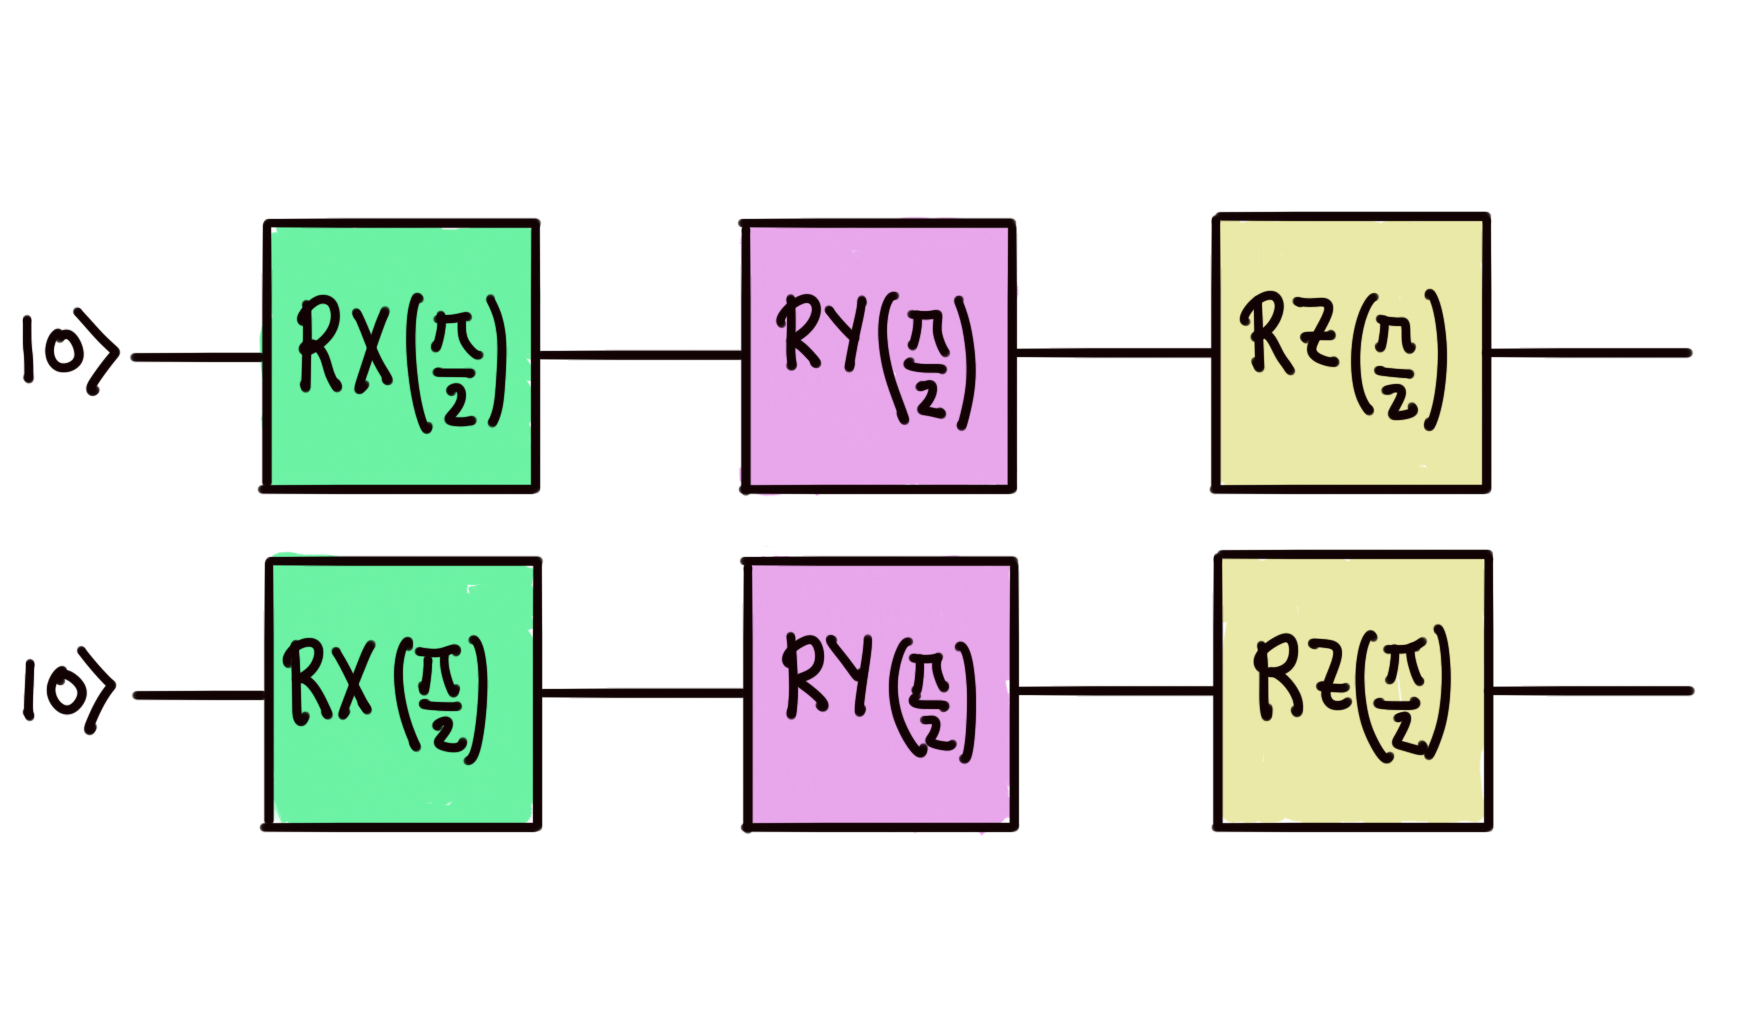">

which contains only Pauli rotations by an angle of $\pi/2$. Your first task will be to use a **quantum transform**, already built for you, to make the rotations dependent on six independent parameters. You will then write an optimization routine to find the parameters that **maximize the fidelity** between the above circuit and the *target circuit* below,

<img src=" 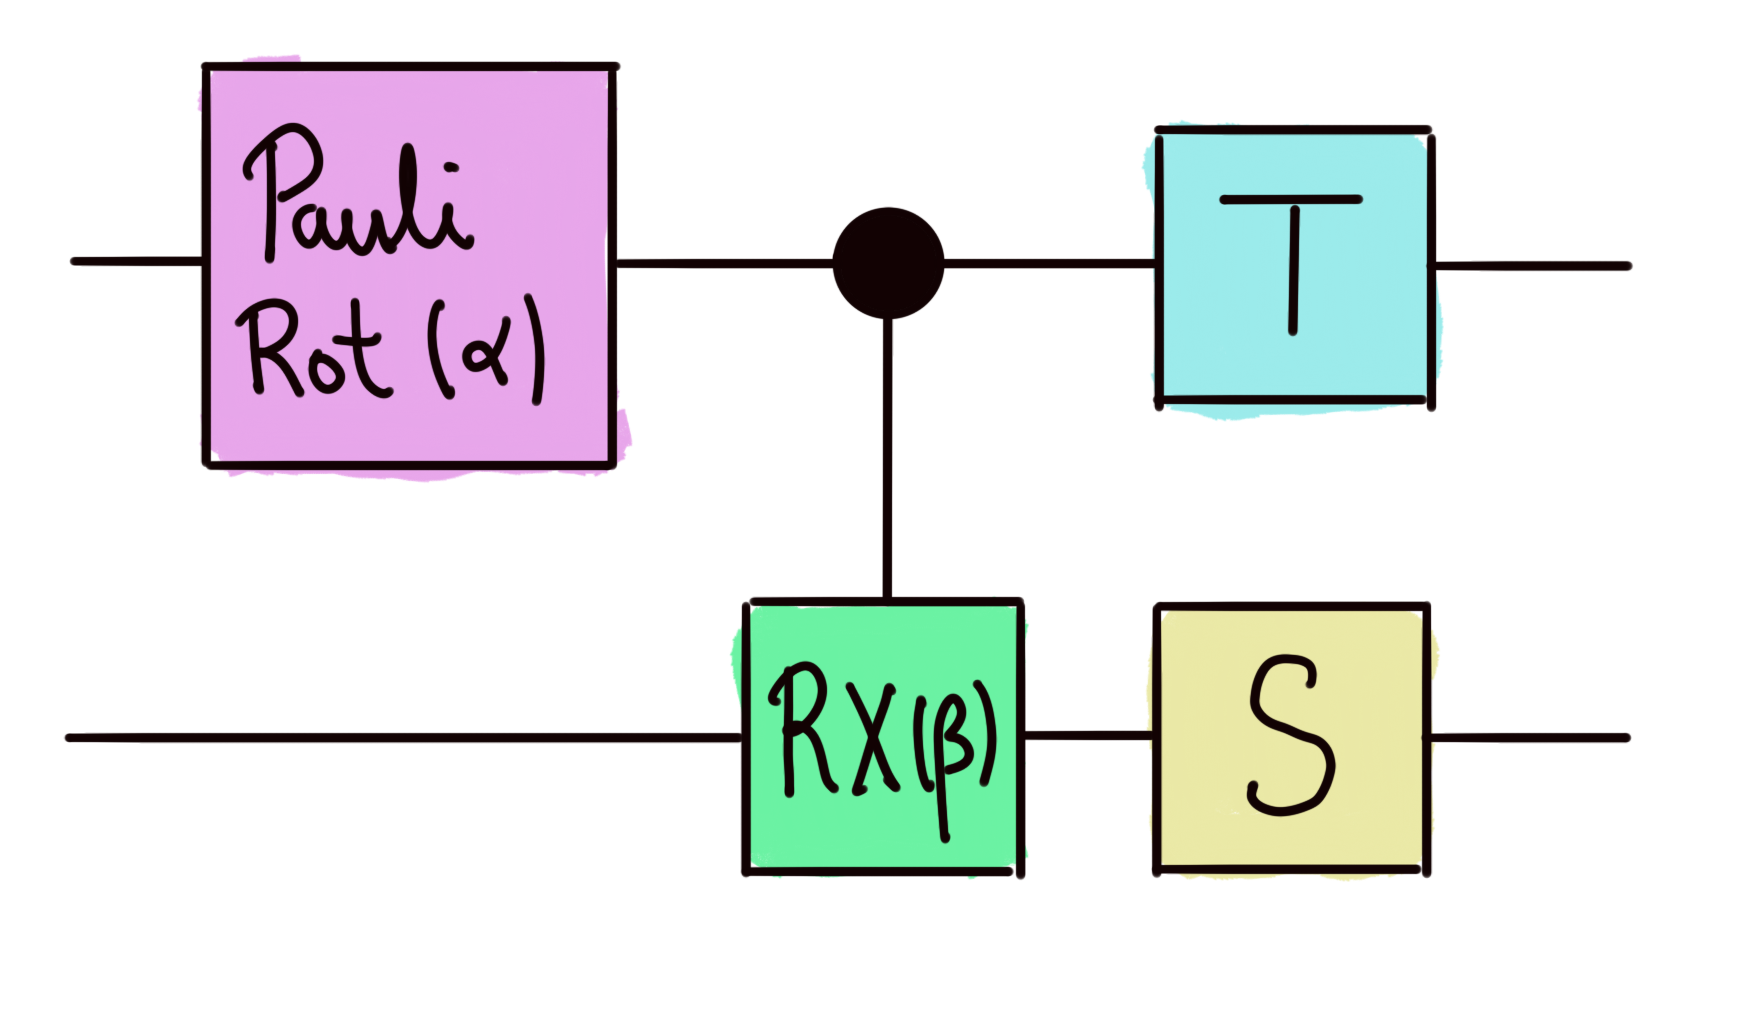">

which depends on a rotation parameter $\alpha$ and a controlled-rotation parameter $\beta$. The rotation at the beginning of the circuit can be a Pauli X, Y, or Z rotation.

## Challenge code

You must complete the `optimal_fidelity` function to find the maximal fidelity between the 2-qubit output states of the transformed available circuit (after adding independent rotation parameters), and the target circuit.

The quantum transform `rotate_rots` rotates each rotation gate in the available circuit `circuit()` by an independent parameter. Use it to your advantage!

## Input

As input to this problem, you are given:
- `target_params (list(float))`: A list of the two angles $\alpha$ and $\beta$ representing the parameters of the target circuit.
- `pauli_word (str)`: A string that can be "X", "Y" or "Z", specifying the initial rotation of the target circuit.

Output

This code will output a `float` corresponding to the maximal fidelity between the output states of both circuits.

If your solution matches the correct one within the given tolerance specified in check (in this case it's an absolute tolerance of `0.01`), the output will be `"Correct!"`. Otherwise, you will receive a `"Wrong answer"` prompt.

Good luck!

In [1]:
import functools
import json
import math
import pandas as pd
import pennylane as qml
import pennylane.numpy as np
import scipy

In [2]:
@qml.qfunc_transform
def rotate_rots(tape, params):
    for op in tape.operations + tape.measurements:
        if op.name == "RX":
            if list(op.wires) == [0]:
                qml.RX(op.parameters[0] + params[0], wires=op.wires)
            else:
                qml.RX(op.parameters[0] + params[1], wires=op.wires)
        elif op.name == "RY":
            if list(op.wires) == [0]:
                qml.RY(op.parameters[0] + params[2], wires=op.wires)
            else:
                qml.RY(op.parameters[0] + params[3], wires=op.wires)
        elif op.name == "RZ":
            if list(op.wires) == [0]:
                qml.RZ(op.parameters[0] + params[4], wires=op.wires)
            else:
                qml.RZ(op.parameters[0] + params[5], wires=op.wires)
        else:
            qml.apply(op)

def circuit():
    qml.RX(np.pi / 2, wires=0)
    qml.RY(np.pi / 2, wires=0)
    qml.RZ(np.pi / 2, wires=0)
    qml.RX(np.pi / 2, wires=1)
    qml.RY(np.pi / 2, wires=1)
    qml.RZ(np.pi / 2, wires=1)


In [3]:
def optimal_fidelity(target_params, pauli_word):

    """This function returns the maximum fidelity between the final state that we obtain with only
    Pauli rotations with respect to the state we obtain with the target circuit

    Args:
        - target_params (list(float)): List of the two parameters in the target circuit. The first is
        the parameter of the Pauli Rotation, the second is the parameter of the CRX gate.
        - pauli_word: A string that is either 'X', 'Y', or 'Z', depending on the Pauli rotation
        implemented by the target circuit.
    Returns:
        - (float): Maximum fidelity between the states produced by both circuits.
    """

    dev = qml.device("default.qubit", wires=2)

    @qml.qnode(dev)
    def target_circuit(target_params, pauli_word):
        """This QNode is target circuit whose effect we want to emulate"""
        # Put your code here #
        qml.PauliRot(target_params[0], pauli_word,  wires=0)
        qml.CRX(target_params[1], wires = [0,1])
        qml.T(wires = 0)
        qml.S(wires = 1)
        
        return qml.state()

    @qml.qnode(dev)
    def rotated_circuit(rot_params):
        """This QNode is the available circuit, with rotated parameters

        Inputs:
        rot_params list(float): A list containing the values of the independent rotation parameters
        for each gate in the available circuit. The order will not matter, since you are optimizing
        for these and will return the minimal value of a cost function (related
        to the fidelity)
        """
        rotate_rots(rot_params)(circuit)()
        
        return qml.state()

    # Write an optimization routine for an adequate cost function.
    def cost(rot_params):
        return qml.math.fidelity(rotated_circuit(rot_params),target_circuit(target_params, pauli_word) )
    
    epochs = 1000
    lr = .1

    grad = qml.grad(cost)
    rot_params = np.random.rand(6) * np.pi
    
    for epoch in range(epochs):
        rot_params += lr * grad(rot_params)
        
    return cost(rot_params)

In [4]:
# These functions are responsible for testing the solution.

def run(test_case_input: str) -> str:

    ins = json.loads(test_case_input)
    output = optimal_fidelity(*ins)

    return str(output)

def check(solution_output: str, expected_output: str) -> None:
    """
    Compare solution with expected.

    Args:
            solution_output: The output from an evaluated solution. Will be
            the same type as returned.
            expected_output: The correct result for the test case.

    Raises:
            ``AssertionError`` if the solution output is incorrect in any way.
    """

    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    assert np.allclose(
        solution_output, expected_output, rtol=1e-2
    ), "Your calculated optimal fidelity isn't quite right."


In [5]:
test_cases = [['[[1.6,0.9],"X"]', '0.9502'], ['[[0.4,0.5],"Y"]', '0.9977']]

In [6]:
for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

Running test case 0 with input '[[1.6,0.9],"X"]'...
Correct!
Running test case 1 with input '[[0.4,0.5],"Y"]'...
Correct!
